In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from lifelines import KaplanMeierFitter

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("test.csv")
print("Test shape:", test.shape )
train = pd.read_csv("train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [2]:
features = ['karnofsky_score', 'dri_score', 'prim_disease_hct', 'obesity', 'donor_related', 'sex_match', 'cyto_score', 'donor_age', 'age_at_hct']
train_clusters = train[features]
train_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   karnofsky_score   27930 non-null  float64
 1   dri_score         28646 non-null  object 
 2   prim_disease_hct  28800 non-null  object 
 3   obesity           27040 non-null  object 
 4   donor_related     28642 non-null  object 
 5   sex_match         28539 non-null  object 
 6   cyto_score        20732 non-null  object 
 7   donor_age         26992 non-null  float64
 8   age_at_hct        28800 non-null  float64
dtypes: float64(3), object(6)
memory usage: 2.0+ MB


In [3]:
CATS = []
for c in features:
    if train_clusters[c].dtype=="object":
        CATS.append(c)
        train_clusters[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 6 CATEGORICAL FEATURES: ['dri_score', 'prim_disease_hct', 'obesity', 'donor_related', 'sex_match', 'cyto_score']


C:\Users\anala\AppData\Local\Temp\ipykernel_29240\197956489.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clusters[c] = train[c].fillna("NAN")


In [4]:
combined = pd.concat([train_clusters],axis=0,ignore_index=True)
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in features:

    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")

    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train_clusters = combined.iloc[:len(train_clusters)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, prim_disease_hct, obesity, donor_related, sex_match, cyto_score, 

In [5]:
train_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   karnofsky_score   27930 non-null  float32 
 1   dri_score         28800 non-null  category
 2   prim_disease_hct  28800 non-null  category
 3   obesity           28800 non-null  category
 4   donor_related     28800 non-null  category
 5   sex_match         28800 non-null  category
 6   cyto_score        28800 non-null  category
 7   donor_age         26992 non-null  float32 
 8   age_at_hct        28800 non-null  float32 
dtypes: category(6), float32(3)
memory usage: 507.9 KB


In [6]:
# Train clustering model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

train_clusters_sclaed = StandardScaler().fit_transform(train_clusters)
train_clusters_sclaed = pd.DataFrame(train_clusters_sclaed, columns=features)

In [7]:
# Fill na with mean
train_clusters_sclaed = train_clusters_sclaed.fillna(train_clusters_sclaed.mean())

Text(0.5, 1.0, 'The Elbow Method')

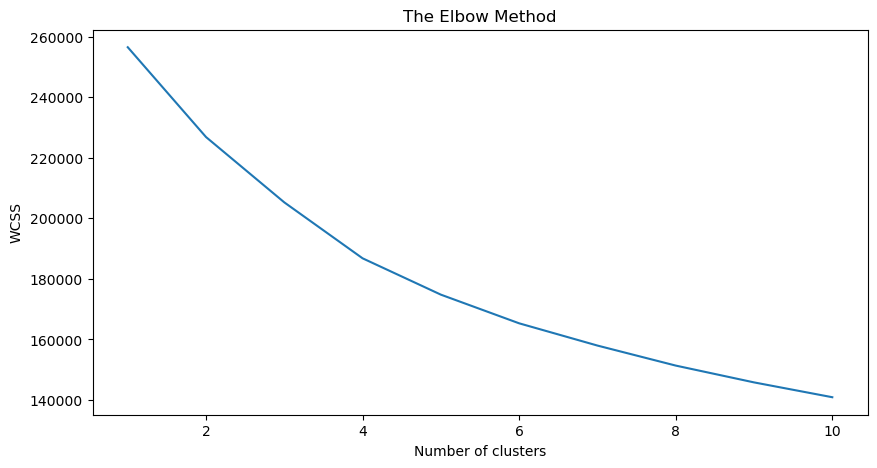

In [8]:
# Plot elbow graph
wcss = []
plt.figure(figsize=(10,5))

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_clusters_sclaed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method')

In [9]:
# Train k_means with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(train_clusters_sclaed)
train_clusters_sclaed["cluster"] = y_kmeans

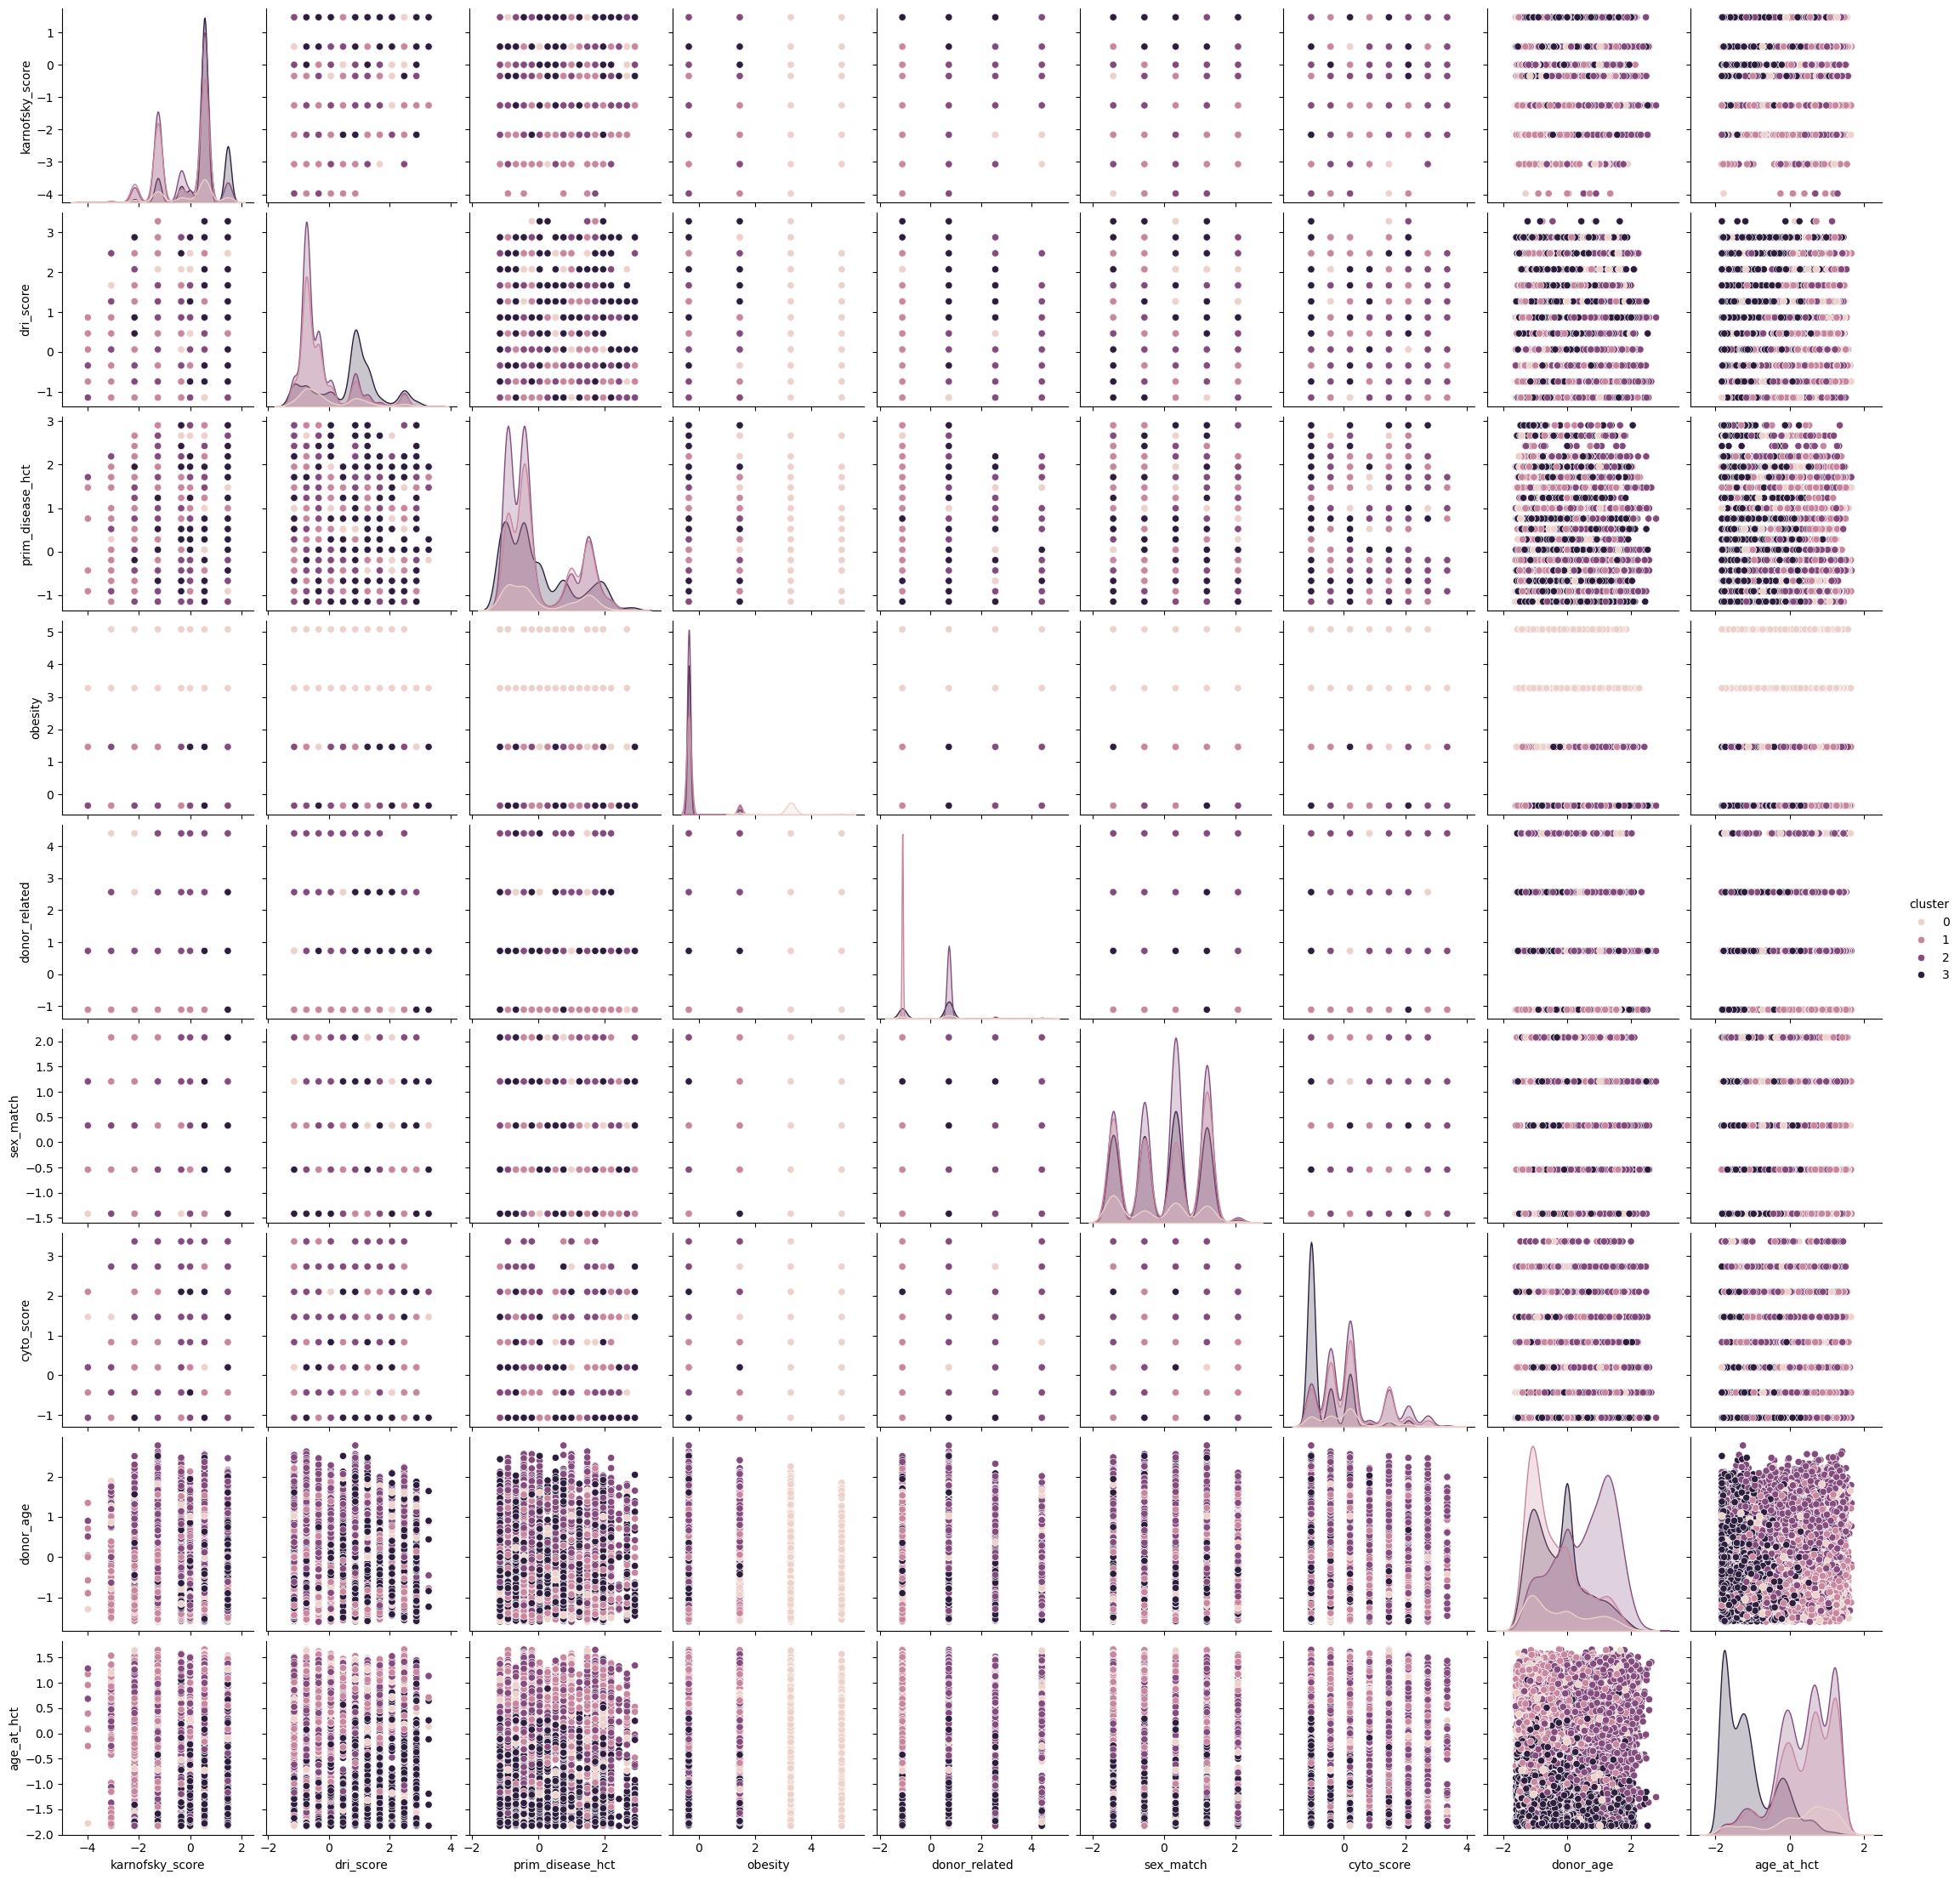

In [10]:
# Plot pairplot
import seaborn as sns
sns.pairplot(train_clusters_sclaed, hue="cluster")

In [11]:
train["cluster"] = train_clusters_sclaed["cluster"]

In [13]:
from lifelines import  NelsonAalenFitter
def create_nelson(data):
    data=data.copy()
    naf = NelsonAalenFitter(nelson_aalen_smoothing=0)
    naf.fit(durations=data['efs_time'], event_observed=data['efs'])
    return naf.cumulative_hazard_at_times(data['efs_time']).values*-1

In [14]:
train['y_nel'] = create_nelson(train)

In [34]:
train['y_nel']

0       -0.779331
1       -0.165150
2       -0.771216
3       -0.783756
4       -0.766364
           ...   
28795   -0.770305
28796   -0.191762
28797   -0.773993
28798   -0.779947
28799   -0.775134
Name: y_nel, Length: 28800, dtype: float64

In [15]:
# Show mean of y_nel for each cluster
train["cluster"] = train_clusters_sclaed["cluster"].values
for i in range(4):
    print(f"Cluster {i}: {train[train['cluster'] == i]['y_nel'].mean()}")

Cluster 0: -0.49810498810661163
Cluster 1: -0.500222367258868
Cluster 2: -0.5263830290065055
Cluster 3: -0.6123634426771091


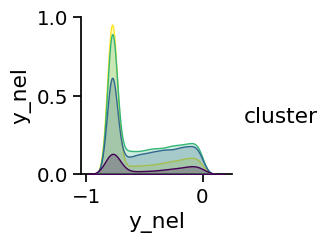

In [26]:
# Plot y_nel graph with each cluster in different color
data = pd.DataFrame({'y_nel': train['y_nel'], 'cluster': train['cluster']})
sns.pairplot(data, hue="cluster", palette='viridis')

<Figure size 1000x600 with 0 Axes>

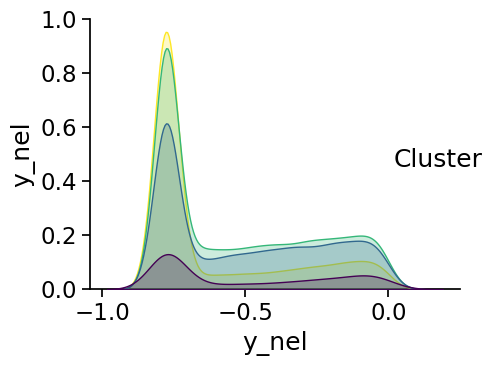

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame para graficar
data = pd.DataFrame({
    'y_nel': train['y_nel'],
    'cluster': train['cluster']
})

# Aumentar tamaño del gráfico
sns.set_context("notebook", font_scale=1.5)  # Aumenta escala de fuente y elementos
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura (opcional si usas pairplot)

# Gráfico con seaborn
g = sns.pairplot(data, hue="cluster", palette='viridis', height=4)

# Agregar leyenda visible y con título
g._legend.set_title("Cluster")
for t in g._legend.texts:
    t.set_fontsize('12')
g._legend.set_bbox_to_anchor((1, 0.5))  # Mover leyenda a un lado si estorba

plt.tight_layout()
plt.show()


Cluster 0: -0.49810498810661163
Cluster 1: -0.500222367258868
Cluster 2: -0.5263830290065055
Cluster 3: -0.6123634426771091


AttributeError: 'tuple' object has no attribute 'get_label'

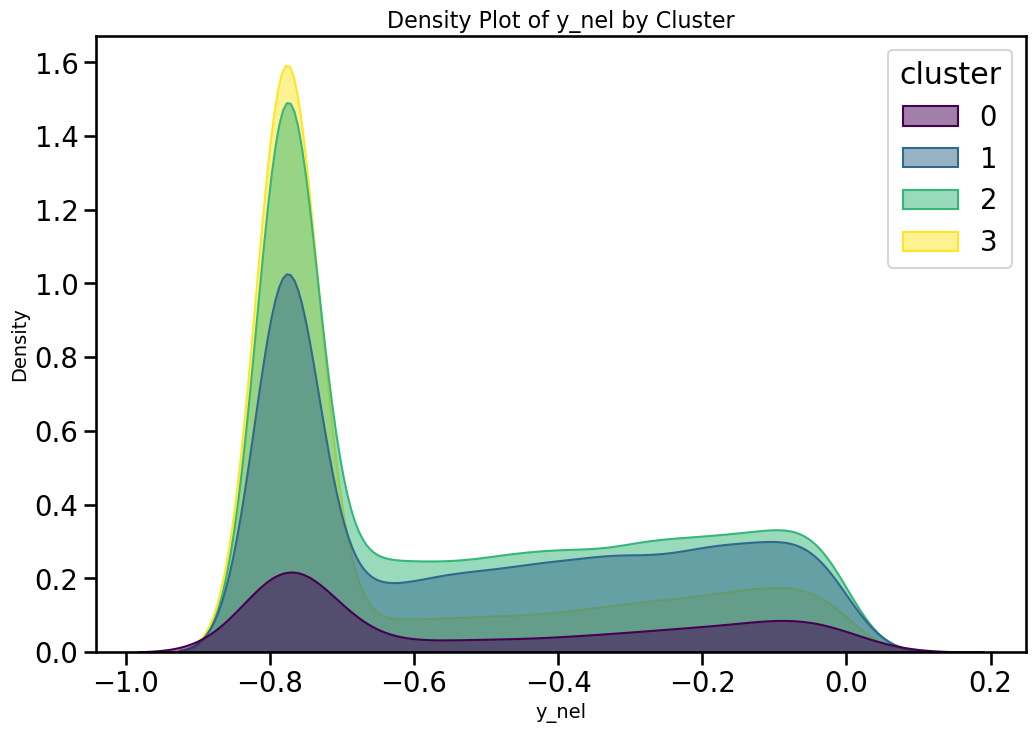

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes el DataFrame 'train' y 'train_clusters_scaled' definido

# Agregar la columna de cluster al DataFrame
train["cluster"] = train_clusters_sclaed["cluster"].values

# Mostrar la media de y_nel para cada cluster
for i in range(4):
    print(f"Cluster {i}: {train[train['cluster'] == i]['y_nel'].mean()}")

# Crear un gráfico de densidad
plt.figure(figsize=(12, 8))  # Ajusta el tamaño de la figura
sns.kdeplot(data=train, x='y_nel', hue='cluster', fill=True, palette='viridis', alpha=0.5)

# Agregar título y etiquetas
plt.title('Density Plot of y_nel by Cluster', fontsize=16)
plt.xlabel('y_nel', fontsize=14)
plt.ylabel('Density', fontsize=14)

handles = []

# Iterar sobre cada cluster y calcular la función de supervivencia
for cluster in sorted(train['cluster'].unique()):  # Ordenar los clusters
    cluster_data = train[train['cluster'] == cluster]
    kmf = KaplanMeierFitter()
    kmf.fit(durations=cluster_data['efs_time'], event_observed=cluster_data['efs'], label=f'Cluster {cluster}')
    #kmf.plot_survival_function()
    
    # Agregar el handle a la lista
    handles.append((kmf, f'Cluster {cluster}'))

# Crear la leyenda con el orden deseado
plt.legend(handles=[(h[0].plot, h[1]) for h in handles], title='Cluster', fontsize='large', title_fontsize='medium', loc='upper right')

# Mostrar el gráfico
plt.show()

AttributeError: 'tuple' object has no attribute 'get_label'

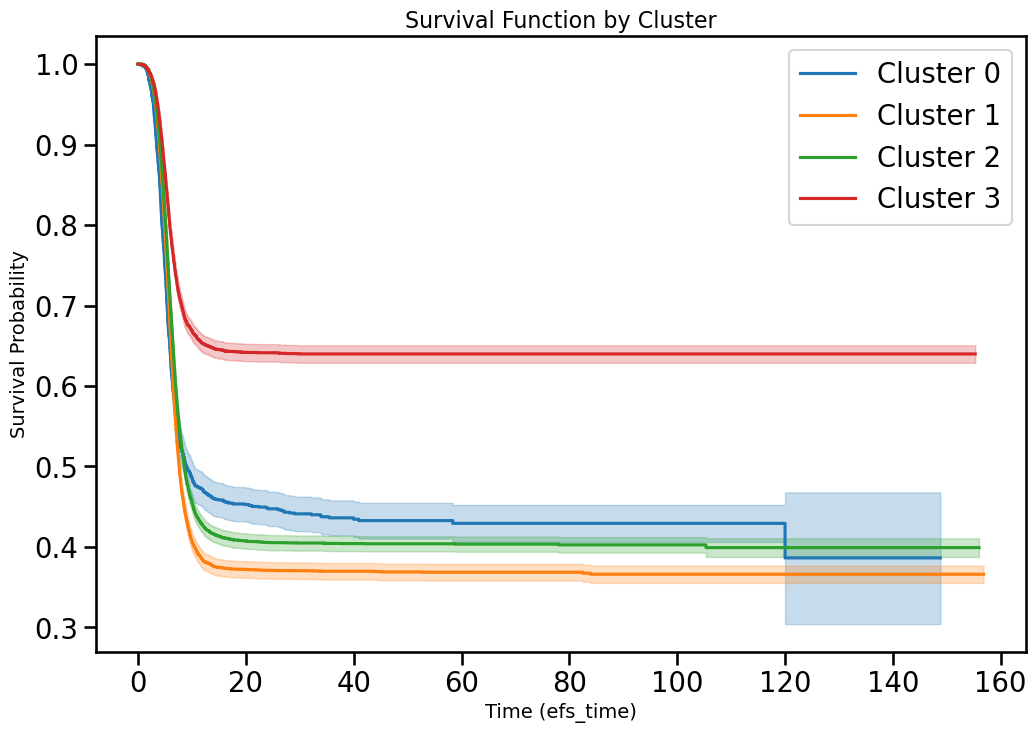

In [44]:
# Crear un gráfico de supervivencia para cada cluster
plt.figure(figsize=(12, 8))

# Lista para almacenar los handles y labels
handles = []

# Iterar sobre cada cluster y calcular la función de supervivencia
for cluster in sorted(train['cluster'].unique()):  # Ordenar los clusters
    cluster_data = train[train['cluster'] == cluster]
    kmf = KaplanMeierFitter()
    kmf.fit(durations=cluster_data['efs_time'], event_observed=cluster_data['efs'], label=f'Cluster {cluster}')
    kmf.plot_survival_function()
    
    # Agregar el handle a la lista
    handles.append((kmf, f'Cluster {cluster}'))

# Agregar título y etiquetas
plt.title('Survival Function by Cluster', fontsize=16)
plt.xlabel('Time (efs_time)', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)

# Crear la leyenda con el orden deseado
plt.legend(handles=[(h[0].plot, h[1]) for h in handles], title='Cluster', fontsize='large', title_fontsize='medium', loc='upper right')
plt.grid()

# Mostrar el gráfico
plt.show()